## Chinook Music Store
The Chinook Record Store Database is like a digital music shop's blueprint, packed with details about artists, songs, albums, customers, and purchases. It's a compact version of iTunes, neatly organizing everything into eleven tables. It's a valuable resource for music lovers and data fans, offering insights into how a music store operates.

<img src = "WhatsApp Image 2024-03-15 at 15.59.20_e4617567.jpg" width = "100%" />

In [235]:
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [236]:
db = 'chinook (1).db'

def run_query(q):
    with sql.connect(db) as conn:
        return pd.read_sql_query(q,conn)

### Genre Analysis for Album Selection: Identifying Top-Selling Genres in the USA

Chinook record store wants to select three albums to add from a list of four new artists, each belonging to different genres. The genres include Hip Hop, Punk, Pop, and Blues. The record label focuses on US artists and plans to advertise in the USA.

| Artist Name        | Genre   |
|--------------------|---------|
| Regal              | Hip-Hop |
| Red Tone           | Punk    |
| Meteor & the Girls | Pop     |
| Slim Jim Bites     | Blues   |

To decide which albums to choose, we need to find out which genres are the most popular in the USA. We'll do this by quering the database to see which genres sell the most tracks in the USA. Based on this information, we will make recommendations for three artists whose albums Chinook should purchase. 

In [237]:
q = """ 
WITH usa_tracks AS
    (SELECT t.genre_id AS genre_id, il.invoice_line_id
    FROM track AS t 
    INNER JOIN invoice_line AS il ON il.track_id = t.track_id
    INNER JOIN invoice AS i ON i.invoice_id = il.invoice_id 
    WHERE i.billing_country = 'USA'
    )
SELECT g.name genre_name,
    COUNT(usa.genre_id) num_purchases, 
    ROUND((CAST(COUNT(usa.genre_id) AS FLOAT)/ (SELECT COUNT(genre_id)
    FROM usa_tracks))*100,2) AS percentage_sold
FROM usa_tracks AS usa 
INNER JOIN genre AS g ON g.genre_id = usa.genre_id

GROUP BY g.name
ORDER BY num_purchases DESC """

df=run_query(q)
df

,genre_name,num_purchases,percentage_sold
0,Rock,561,53.38
1,Alternative & Punk,130,12.37
2,Metal,124,11.80
3,R&B/Soul,53,5.04
4,Blues,36,3.43
5,Alternative,35,3.33
6,Pop,22,2.09
7,Latin,22,2.09
8,Hip Hop/Rap,20,1.90
9,Jazz,14,1.33


C:\Users\Administrator\AppData\Local\Temp\ipykernel_31424\3980987659.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(df["genre_name"], fontsize = 10.5, color = "Grey")


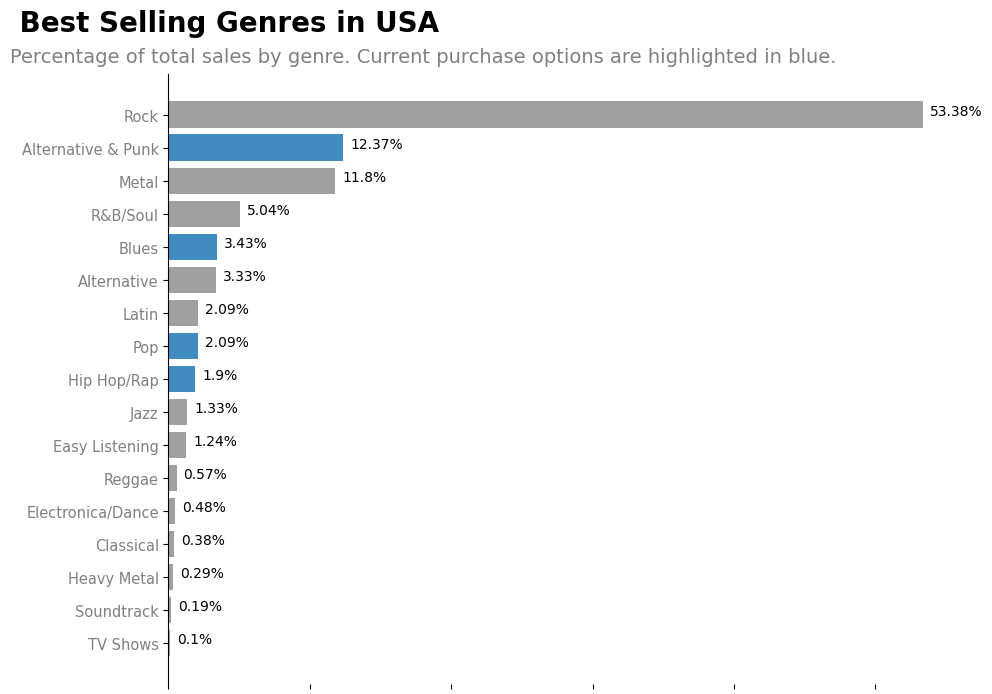

In [238]:
import matplotlib.pyplot as plt
# Sorting the DataFrame by percentage sold
df = df.sort_values(by='percentage_sold')
# Creating a color map to identify key albums of interest
album_options = ["Hip Hop/Rap", "Alternative & Punk", "Blues", "Pop"]
cmap = df["genre_name"].apply(lambda x: '#0064AB' if x in album_options else 'Grey')
# Plotting Data
fig, ax = plt.subplots(figsize=(10, 7))  # Adjust figsize as needed
bars = ax.barh(df["genre_name"], df["percentage_sold"], height=0.8, color=cmap, alpha=0.75, linewidth=1.5)
# Adding data labels and percentages at the end of each bar
for bar, perc in zip(bars, df["percentage_sold"]):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2, f"{perc}%",
            color='black', fontsize=10)
#Customizing axes and layout
ax.set_yticklabels(df["genre_name"], fontsize = 10.5, color = "Grey")
ax.set_xticklabels([])
for i in ["top", "right", "bottom"]:
    plt.gca().spines[i].set_visible(False)
plt.text(-0.2, 1.07, " Best Selling Genres in USA", fontsize=20, fontweight="bold", transform=plt.gca().transAxes, color="Black")
plt.text(-0.2, 1.02, "Percentage of total sales by genre. Current purchase options are highlighted in blue.", fontsize=14, transform=plt.gca().transAxes, color="grey")


plt.tight_layout()
plt.show()


#### Results

Based on the genre sales pattern in USA. Chinook should select these options from the list of available options:
* Punk: Red Tone
* Blues: Slim Jim Bites 
* Pop: Meteor and the Girls

It's worth noting that these genres only make up 17% of total sales. To maximize profitability, the company should be on the lookout for Rock songs since they account for 53% of sales in the US market.

#### Employee Sales Performance Analysis

###### Situation
After an initial purchase, each Chinook customer is assigned to a sales support agent. The company asked us to analyze purchases from customers belonging to each sales agent. They want to know if some agents are performing better or worse than others.
###### Analysis
To answer this question, we need to extract the names of sales executives, their hire dates,the number of accounts they handle and total purchases made by these accounts. We will also compute the average sales for each account that the sales executive manage.

In [239]:
q = """
WITH t1 AS(SELECT em.first_name || ' ' || em.last_name AS sales_rep_name,
            em.hire_date, COUNT(cu.customer_id) AS num_invoices,
            CAST(SUM(iv.total) AS INTEGER) AS total_sales
            FROM employee em
            JOIN customer cu
            ON em.employee_id = cu.support_rep_id
            JOIN invoice iv 
            ON iv.customer_id = cu.customer_id
            GROUP BY 1
            ORDER BY 4 DESC)
            
SELECT *, ROUND(CAST(total_sales AS FLOAT)/num_invoices,2) 
AS sales_per_customer FROM t1;
"""
df = run_query(q)
df

,sales_rep_name,hire_date,num_invoices,total_sales,sales_per_customer
0,Jane Peacock,2017-04-01 00:00:00,212,1731,8.17
1,Margaret Park,2017-05-03 00:00:00,214,1584,7.40
2,Steve Johnson,2017-10-17 00:00:00,188,1393,7.41


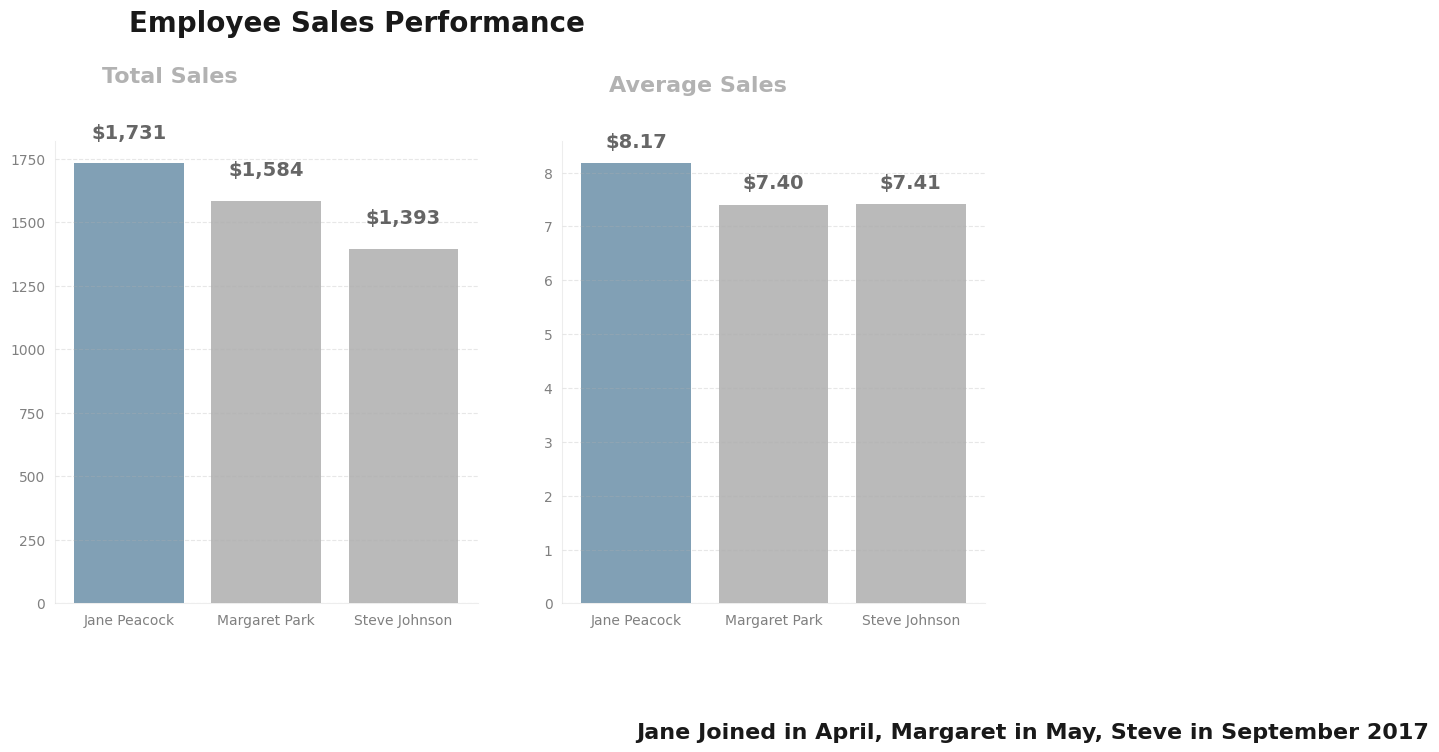

In [240]:
import matplotlib.pyplot as plt
# Data
sales_rep_name = df["sales_rep_name"].values
total_sales = df["total_sales"].values
sales_per_customer = df["sales_per_customer"].values
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
# Total sales chart
axes[0].bar(sales_rep_name, total_sales, color='#BABABA', width=0.8, label='Total Sales')
axes[0].bar(sales_rep_name[0], total_sales[0], color='#0064AB', alpha=0.3, width=0.8)
axes[0].text(x=-0.2, y=2050, s='Total Sales', size=16, fontweight='bold', alpha=0.3)
for sales, index in zip(total_sales, range(len(total_sales))):
    axes[0].text(x=index, y=sales + 100, s='${:,}'.format(sales), ha='center', fontweight='bold', alpha=0.6, size=14)
axes[0].text(x=0, y=2250, s='Employee Sales Performance', size=20, fontweight='bold', alpha=0.9)
# Average sales chart
axes[1].bar(sales_rep_name, sales_per_customer, color='#BABABA', width=0.8, label='Average Sales')
axes[1].bar(sales_rep_name[0], sales_per_customer[0], color='#0064AB', alpha=0.3, width=0.8)
axes[1].text(x=-0.2, y=9.5, s='Average Sales', size=16, fontweight='bold', alpha=0.3)
for sales, index in zip(sales_per_customer, range(len(sales_per_customer))):
    axes[1].text(x=index, y=sales + 0.3, s='${:,.2f}'.format(sales), ha='center', fontweight='bold', alpha=0.6, size=14)
axes[1].text(x=0, y=-2.5, s='Jane Joined in April, Margaret in May, Steve in September 2017', size=16, fontweight='bold', alpha=0.9)
# Common attributes to both charts
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#DDD')
    ax.spines['left'].set_alpha(0.5)
    ax.spines['bottom'].set_color('#DDD')
    ax.spines['bottom'].set_alpha(0.5)
    ax.tick_params(left=False, bottom=False, labelsize=10, labelcolor='grey')
    ax.grid(axis='y', linestyle='--', alpha=0.3)

plt.show()

#### Results
* Of the three sales employees, Jane acheived the highest total sales of 1,731 dollars. Margaret Park comes second, and Steve occupies last place with 1,393 dollars in sales. The difference in sales is understandable considering that Jane and Margaret were employeed about five months before Steve.
* Jane's average sales numberssupport her leading position. She has achieved 8.17 dollars in sales per customer, the highest of the three employees. Steve also performs marginally better than Margaret despite the difference in their employement dates. 

#### Sales by Country
###### Situation
Chinook wants to understand how sales are distributed across different countries. The company intends to identify countries with growth potential and may even run advertising campaign in these countries.
###### Analysis
To answer this question, we will write a query that collates data on purchases from different countries. For each country, we will include the total number of customers, total sales value, average sales per customer, and the average order value. Where a country has only one customer, we will collect it into an "Other" group:

In [241]:
q = """
WITH t1 AS(SELECT country, COUNT(customer_id) AS num_customers 
            FROM customer 
            GROUP BY country),
            t2 AS(SELECT cu.country, ROUND(SUM(iv.total),2) AS total_sales,
            COUNT(iv.invoice_id) AS num_sales
            FROM customer cu
            JOIN invoice iv
            ON cu.customer_id = iv.customer_id
            GROUP BY 1),
            t3 AS(SELECT CASE WHEN t1.num_customers = 1 THEN 'OTHERS'
                            ELSE t1.country END AS countries,
                SUM(t1.num_customers) AS num_customers,
                SUM(t2.total_sales) AS total_sales,
                SUM(t2.num_sales) AS num_sales
            FROM t1
            JOIN t2
            ON t1.country = t2.country
            GROUP BY 1)
            
            SELECT countries,
                    num_customers,
                    total_sales,
                    ROUND(total_sales/num_sales,2) AS avg_order_value,
                    ROUND(total_sales/num_customers,2) AS sales_per_customer
            FROM (
                    SELECT *,
                            CASE WHEN countries = 'Others' THEN 1
                                    ELSE 0 END AS sort
                            FROM t3
                )
        ORDER BY sort, num_customers DESC;
"""
df = run_query(q)
df

,countries,num_customers,total_sales,avg_order_value,sales_per_customer
0,OTHERS,15,1094.94,7.45,73.00
1,USA,13,1040.49,7.94,80.04
2,Canada,8,535.59,7.05,66.95
3,Brazil,5,427.68,7.01,85.54
4,France,5,389.07,7.78,77.81
5,Germany,4,334.62,8.16,83.66
6,United Kingdom,3,245.52,8.77,81.84
7,Czech Republic,2,273.24,9.11,136.62
8,India,2,183.15,8.72,91.58
9,Portugal,2,185.13,6.38,92.57


In [242]:
avg_cust_purchase = df.sales_per_customer.mean()
print(avg_cust_purchase)
df['pcent_customer'] = round(100*df.num_customers/df.num_customers.sum(),1)
df['pcent_sales'] = round(100*df.total_sales/df.total_sales.sum(),1)
df['cust_purchase_diff']=round(100*(df.sales_per_customer-avg_cust_purchase),2)


86.96100000000001


In [243]:
df

,countries,num_customers,total_sales,avg_order_value,sales_per_customer,pcent_customer,pcent_sales,cust_purchase_diff
0,OTHERS,15,1094.94,7.45,73.00,25.4,23.2,-1396.1
1,USA,13,1040.49,7.94,80.04,22.0,22.1,-692.1
2,Canada,8,535.59,7.05,66.95,13.6,11.4,-2001.1
3,Brazil,5,427.68,7.01,85.54,8.5,9.1,-142.1
4,France,5,389.07,7.78,77.81,8.5,8.3,-915.1
5,Germany,4,334.62,8.16,83.66,6.8,7.1,-330.1
6,United Kingdom,3,245.52,8.77,81.84,5.1,5.2,-512.1
7,Czech Republic,2,273.24,9.11,136.62,3.4,5.8,4965.9
8,India,2,183.15,8.72,91.58,3.4,3.9,461.9
9,Portugal,2,185.13,6.38,92.57,3.4,3.9,560.9


In [249]:
136.62-86.96100000000001

49.65899999999999

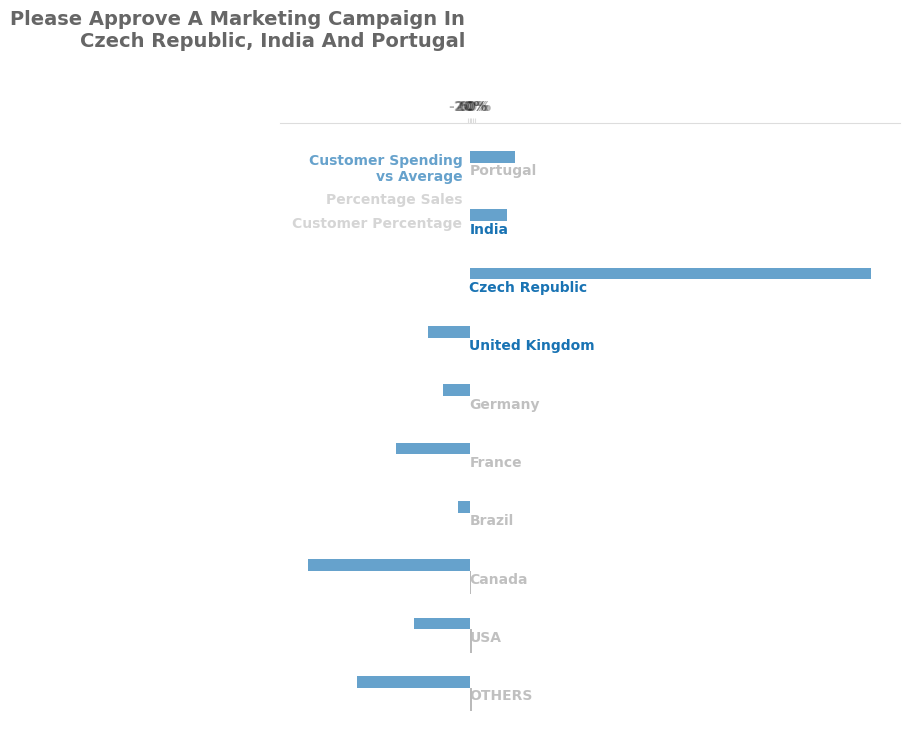

In [244]:
# Visualization 
y_labs = df.countries.values
y_axes = np.arange(df.countries.size)

fig = plt.figure(figsize=(8,8))
plt.barh(y_axes-0.3,df.pcent_customer,height=0.2,color='#BABABA')
plt.barh(y_axes-0.1,df.pcent_sales,height=0.2,color='#BABABA')
plt.barh(y_axes+0.1,df.cust_purchase_diff,height=0.2,color='#0064AB',alpha=0.6)

color_map = ['','','','','','','Yes','Yes','Yes','']
# Annonate y axis ticks
for loc, label, color in zip(y_axes,y_labs,color_map):
    if color == 'Yes':
        plt.text(x=-3,y=loc-0.2, s=label, color='#0064AB',
                alpha=0.9,size=10,fontweight='bold')
    else:
        plt.text(x=-3,y=loc-0.2, s=label, color='#BABABA',
                alpha=0.9,size=10,fontweight='bold')
# Set plot legend
plt.text(x=-90,y=8.7, s="Customer Spending\nvs Average", ha='right',
         color='#0064AB',alpha=0.6,size=10,fontweight='bold')
plt.text(x=-90,y=8.3, s="Percentage Sales", ha='right',
         color='#BABABA',alpha=0.6,size=10,fontweight='bold')
plt.text(x=-90,y=7.9, s="Customer Percentage", ha='right',
         color='#BABABA',alpha=0.6,size=10,fontweight='bold')
# Set plot title 
plt.text(x=-60,y=11, s="Please Approve A Marketing Campaign In\nCzech Republic, India And Portugal", 
         ha='right',alpha=0.6,size=14,fontweight='bold')

for ax in fig.get_axes():
    plt.sca(ax)
    sns.despine(left=True,bottom=True,top=False)
    ax.tick_params(left=False,bottom=False,color="#ddd")
    ax.xaxis.set_ticks_position('top')
    ax.spines['top'].set_color('#DDD')
    plt.yticks([])
    plt.xticks([-20,0,20,40,60],['-20%','0','20%','40%','60%'],
              size=10,alpha=0.3,fontweight='bold')
    
plt.show()

#### Results
* The Majority of Chinook sales arise from US and Canada. These two countries dominate in customer base as well as sales. However, customers spend lesser per invoice in these countries.
* Although the Czech Republic, Portugal, and India record fewer customers and lesser sales values, customers spend more per invoice than in other countries. To increase revenue from these three markets, Chinook could run marketing campaigns to expand its customer base.

Since the data from each country are relatively few, the initial marketing campaigns should be small. They should aim to collect and analyze customer data so that the right trends are confidently identified.

###### How Many Tracks Never Sell?
To answer this question, we will have to distinguish between the entire inventory of tracks in the track table and the distinct instances of tracks from the invoice_line table.

In [245]:
q= """
WITH all_and_purchased AS
(
SELECT t.track_id all_tracks, il.track_id AS purchased_tracks
FROM track AS t
LEFT JOIN invoice_line il ON il.track_id = t.track_id
)
SELECT COUNT(DISTINCT a.all_tracks) total_tracks,
COUNT(DISTINCT a.purchased_tracks) tracks_purchased,
COUNT(DISTINCT a.all_tracks) - COUNT(DISTINCT a.purchased_tracks) not_purchased,
ROUND(COUNT(DISTINCT a.purchased_tracks)/CAST(COUNT(DISTINCT a.all_tracks) AS FLOAT),2) percent_purchased
FROM all_and_purchased AS a;
"""
df=run_query(q)
df

,total_tracks,tracks_purchased,not_purchased,percent_purchased
0,3503,1806,1697,0.52


In [246]:
purchased = df.T
purchased = purchased.iloc[[1,2],0]
purchased_list = purchased.tolist()

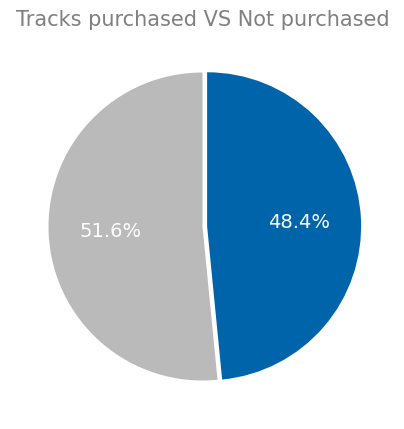

In [247]:
# Plot 
plt.pie(purchased_list,explode=(0,0.03),startangle=90,autopct='%1.1f%%',
        textprops={'fontsize':14,'color':'white'},
        colors=('#BABABA','#0064AB')
)
#Plot Aesthetics
plt.title("Tracks purchased VS Not purchased", fontsize=15,color='gray')
fig = plt.gcf()
fig.set_size_inches(5,5)
plt.show()

#### Observations
* Surprisingly, almost half of the track inventory at Chinook has not sold. Lets take a look at the bottom performers and see of we can learn more:

In [248]:
q="""
SELECT ar.name artist_name, g.name genre, COUNT(il.track_id) units_sold
FROM track t
LEFT JOIN invoice_line il ON il.track_id = t.track_id
INNER JOIN album al ON al.album_id = t.album_id
INNER JOIN artist ar ON ar.artist_id = al.artist_id
INNER JOIN genre as g ON g.genre_id = t.genre_id
GROUP BY artist_name
HAVING units_sold = 0
ORDER BY units_sold;
"""
run_query(q)

,artist_name,genre,units_sold
0,Aaron Copland & London Symphony Orchestra,Classical,0
1,Academy of St. Martin in the Fields Chamber En...,Classical,0
2,"Academy of St. Martin in the Fields, John Birc...",Classical,0
3,"Academy of St. Martin in the Fields, Sir Nevil...",Classical,0
4,Adrian Leaper & Doreen de Feis,Classical,0
...,...,...,...
69,The Office,TV Shows,0
70,The Tea Party,Alternative & Punk,0
71,Ton Koopman,Classical,0
72,Toquinho & Vinícius,Bossa Nova,0


#### Observations
74 artists have not sold any units, with most of these tracks belonging to the classical music genre.
Half of the company's inventory remains unsold, potentially trying up woeking capital without generating returns. 
Depending on the payment arrangement with record labels, there are two scenarios to consider:

1. If Chinook pays a fixed fee to host these tracks, it might be wise to focus on more popular genres and discontinues signing less succesful artists.

2. If Chinook pays the record label based on sales percentage, there is little downside to keeping the tracks in the store.

Regardless of the scenario, Chinook should explore ways to promote these low-selling artists. Suggestions could be integrated into the purchasing process or displayed on the website's cart page to increase exposure.

#### Albums VS Individual Tracks
The Chinook store allows customers to buy music in two ways: either album or as individual track. However individuals cant buy a full album then add individual tracks to the same purchase unless they select each track manually.When customer purchase albums, they are charged the same price as if they had bought each track seperately.
Management is contemplating a new purchasing approach to cut costs. Instead of buying every track on album, they are considering purchasing only the most popular tracks from each album from record companies.